In [30]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import numpy as np
np.random.seed(42)

import pandas as pd
pd.set_option("display.float_format", lambda x: "%.4f" % x)
pd.set_option("display.max_colwidth", None)

import string
import re
import nltk
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, RepeatVector, TimeDistributed, Dropout
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

from nltk.translate.bleu_score import corpus_bleu

import warnings
warnings.filterwarnings('ignore')
tf.__version__


/kaggle/input/arabic/sa-ar.csv
/kaggle/input/arabic4/sa-ar.csv
/kaggle/input/out-oiu/eng_-french.csv
/kaggle/input/arabic5/sa-ar.csv
/kaggle/input/arabic2/sa-ar.csv
/kaggle/input/language-translation-englishfrench/eng_-french.csv
/kaggle/input/arbic3/sa-ar.csv


'2.15.0'

In [31]:
df = pd.read_csv('/kaggle/input/arabic5/sa-ar.csv', nrows=20000)
df = df.sample(frac=1).reset_index(drop=True)
df.head()
df.shape

(448, 2)

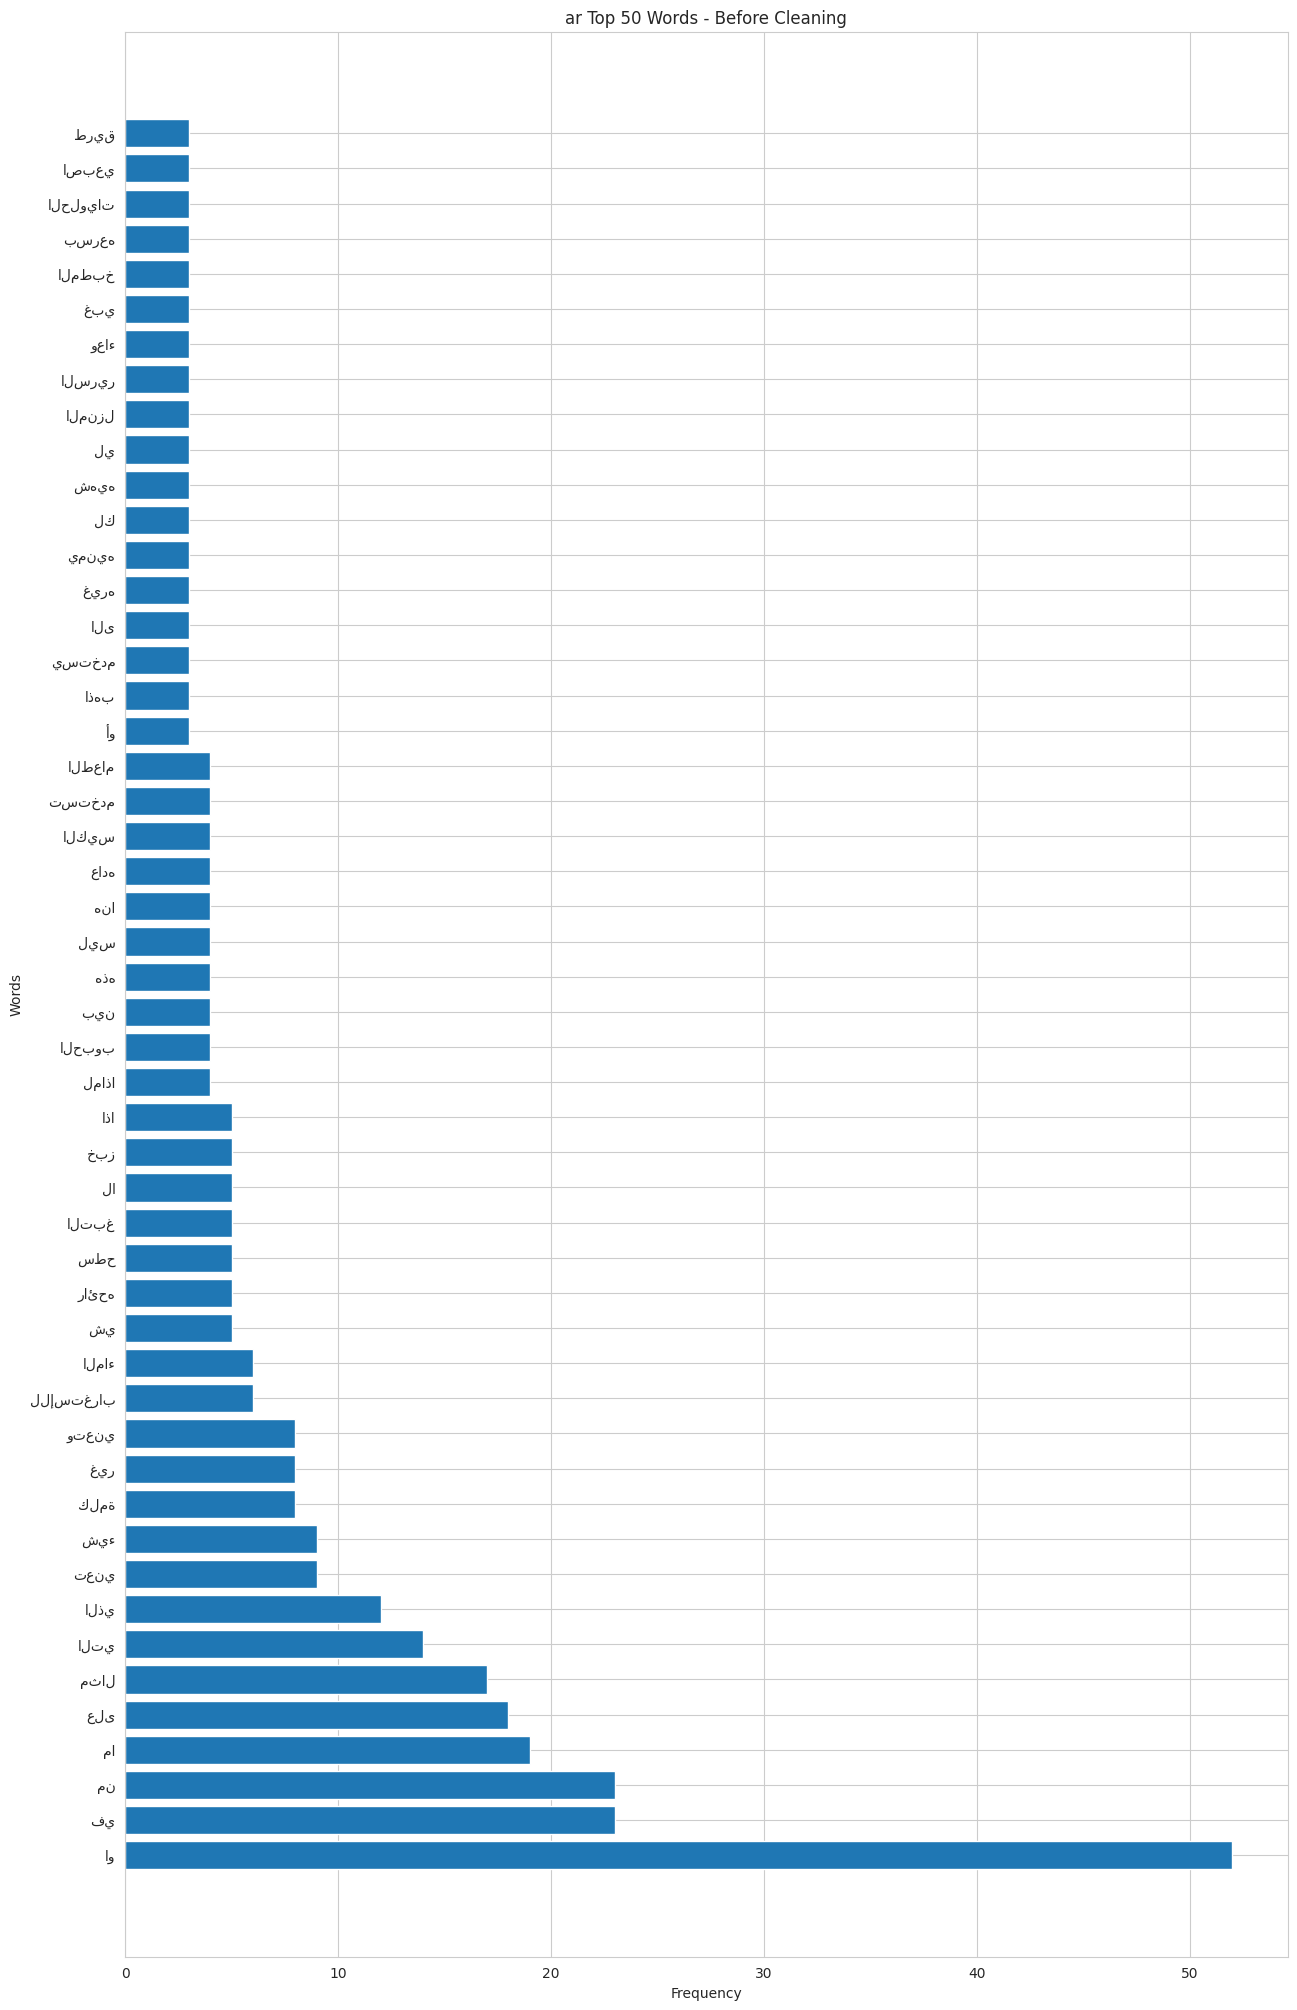

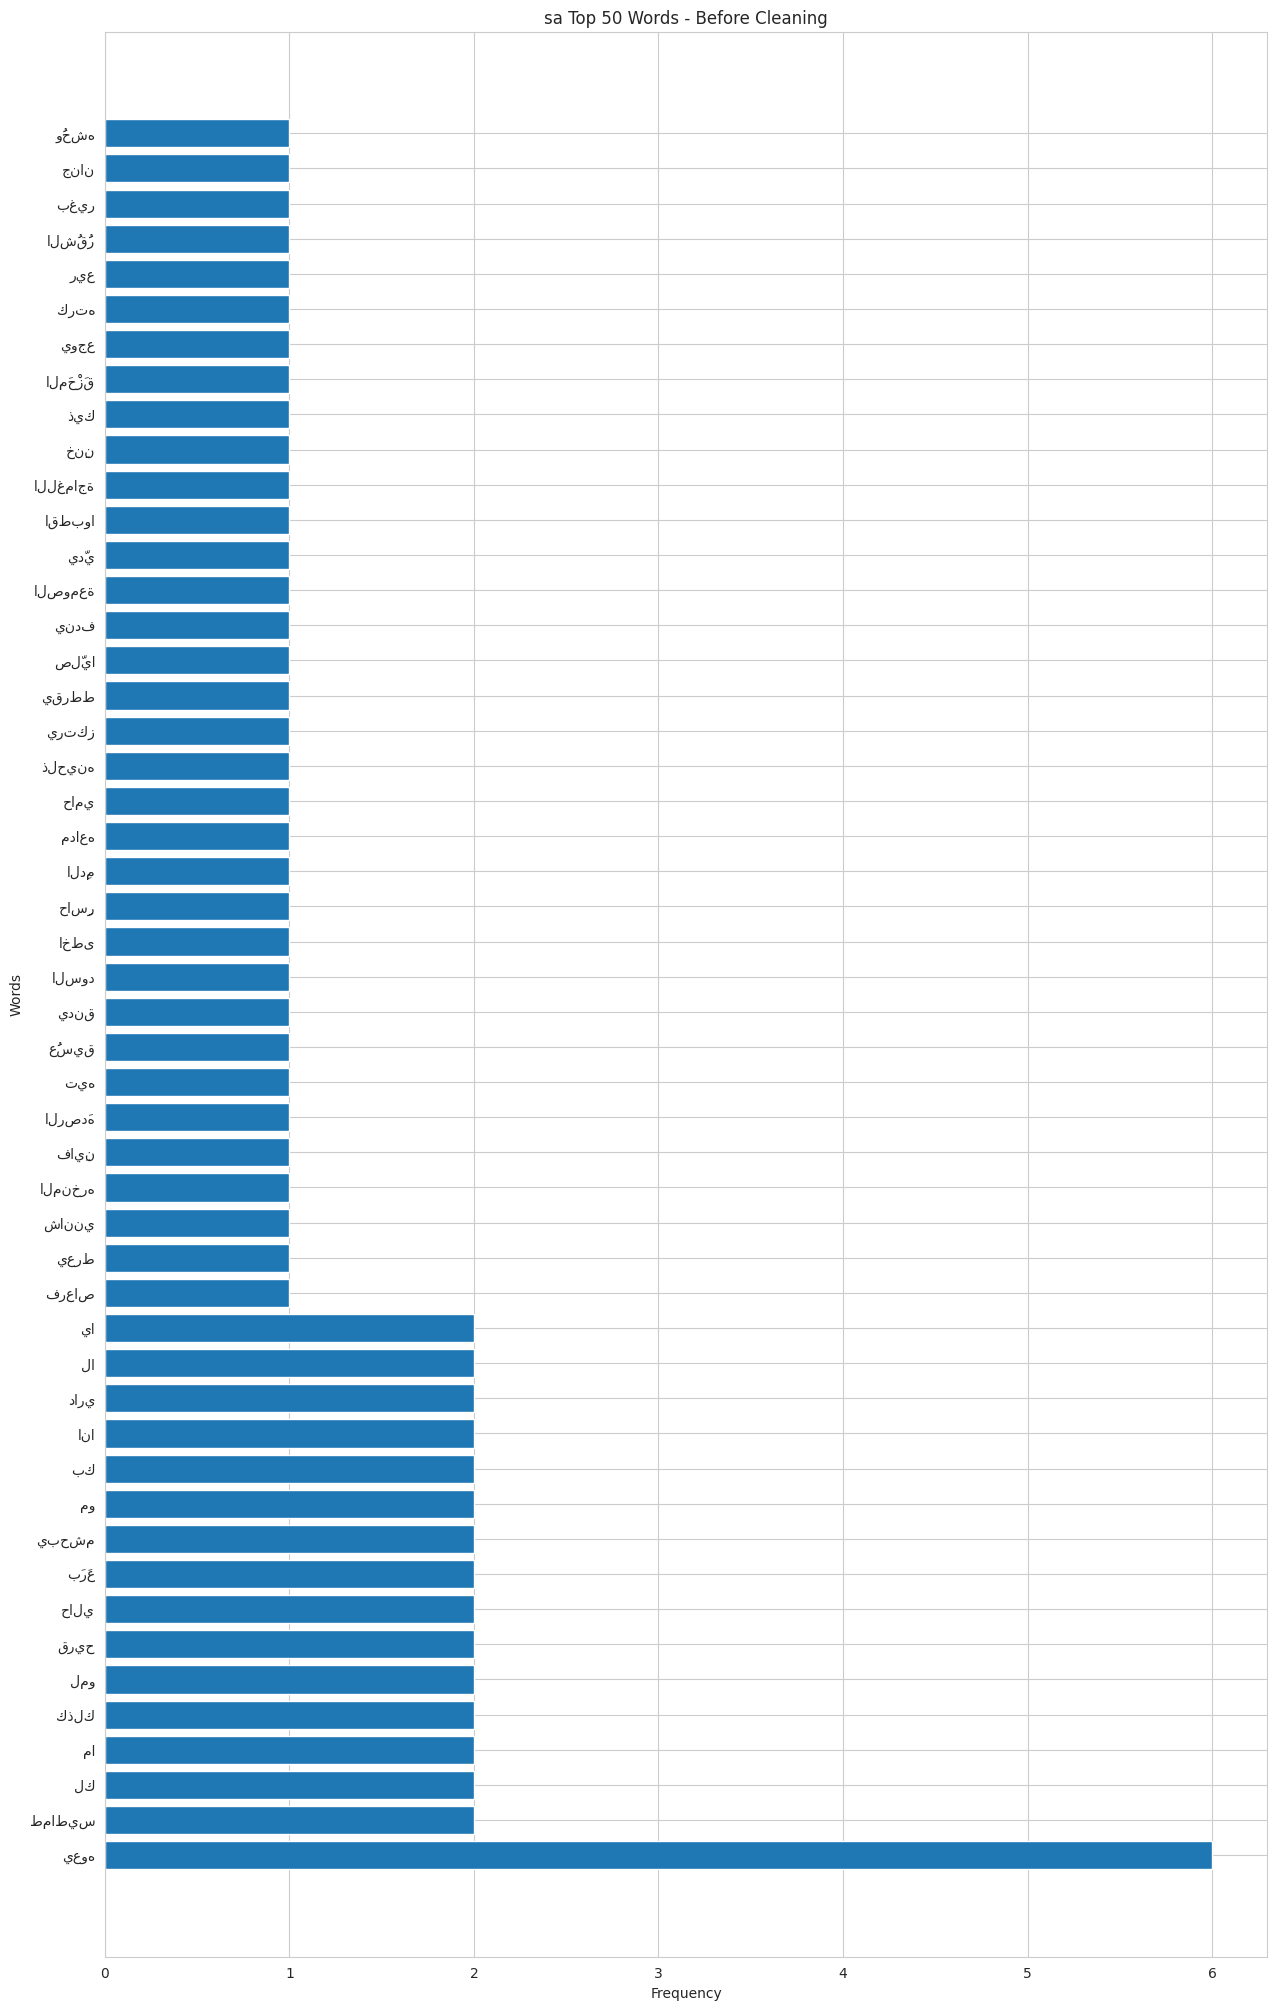

In [32]:
def word_freq(data, label, title):
    freq_df = data[[label]]
    freq_words = freq_df[label].values
    freq_words = [i.lower() for i in freq_words]
    freq_punc = []

    for o in freq_words:
        freq_punc += nltk.word_tokenize(o)

    freq_punc = [o for o in freq_punc if o not in string.punctuation]
    freq_freq = Counter(freq_punc)

    freq_top = freq_freq.most_common(50)

    words = [word for word, _ in freq_top]
    counts = [count for _, count in freq_top]

    plt.figure(figsize=(15, 25))
    plt.barh(words, counts)
    plt.title(title)
    plt.xlabel("Frequency")
    plt.ylabel("Words")

    return freq_top

en_freq_top = word_freq(df, "ar words/sentences", "ar Top 50 Words - Before Cleaning")

fr_freq_top = word_freq(df, "sa words/sentences", "sa Top 50 Words - Before Cleaning")

def clean_text(text):
    text = text.replace("\u202f", " ")
    text = text.lower()
    text = re.sub(r"\d", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = text.strip()
    return text



In [33]:
df["ar words/sentences"] = df["ar words/sentences"].apply(clean_text)
df["sa words/sentences"] = df["sa words/sentences"].apply(clean_text)

data_array = df.values

train_size = int(0.9 * len(data_array))

train_data = data_array[:train_size]
test_data = data_array[train_size:]

idx_en = 0
idx_fr = 1

en_tokenizer = Tokenizer()
en_tokenizer.fit_on_texts(data_array[:, idx_en])
en_vocab_size = len(en_tokenizer.word_index) + 1
en_maxlen = max(len(data.split()) for data in data_array[:, idx_en])

print("ar Vocabulary Size:", en_vocab_size)
print("ar-sana`a Max Length:", en_maxlen)

ar Vocabulary Size: 472
ar-sana`a Max Length: 4


In [34]:

fr_tokenizer = Tokenizer()
fr_tokenizer.fit_on_texts(data_array[:, idx_fr])
fr_vocab_size = len(fr_tokenizer.word_index) + 1
fr_maxlen = max(len(data.split()) for data in data_array[:, idx_fr])

print("ar-sana`a Vocabulary Size:", fr_vocab_size)
print("ar-sana`a Max Length:", fr_maxlen)



ar-sana`a Vocabulary Size: 956
ar-sana`a Max Length: 16


In [35]:
X_train = en_tokenizer.texts_to_sequences(train_data[:, idx_en])
X_train = pad_sequences(X_train, maxlen=en_maxlen, padding='post')

y_train = fr_tokenizer.texts_to_sequences(train_data[:, idx_fr])
y_train = pad_sequences(y_train, maxlen=fr_maxlen, padding='post')
y_train = np.array([to_categorical(seq, num_classes=fr_vocab_size) for seq in y_train])

X_test = en_tokenizer.texts_to_sequences(test_data[:, idx_en])
X_test = pad_sequences(X_test, maxlen=en_maxlen, padding='post')

y_test = fr_tokenizer.texts_to_sequences(test_data[:, idx_fr])
y_test = pad_sequences(y_test, maxlen=fr_maxlen, padding='post')
y_test = np.array([to_categorical(seq, num_classes=fr_vocab_size) for seq in y_test])

In [36]:

model = Sequential()
model.add(Embedding(en_vocab_size, 512, input_length=en_maxlen, mask_zero=True))
model.add(LSTM(256))
model.add(RepeatVector(fr_maxlen))
model.add(LSTM(256, return_sequences=True))
model.add(TimeDistributed(Dense(512, activation='relu')))
model.add(Dropout(0.2))
model.add(TimeDistributed(Dense(fr_vocab_size, activation='softmax')))

model.compile(optimizer='adam', loss='categorical_crossentropy')

early_stopping = EarlyStopping(monitor="val_loss", patience=5)
checkpoint = ModelCheckpoint(filepath=f'sa-ar.h5', monitor='val_loss', verbose=0, save_best_only=True, mode='min')

history = model.fit(
    X_train, y_train, 
    epochs=100, 
    batch_size=64, 
    validation_split=0.1, 
    callbacks=[early_stopping, checkpoint]
)

history_df = pd.DataFrame(history.history)
history_df.head()

Epoch 1/100
6/6 [==============================] - 8s 483ms/step - loss: 6.8132 - val_loss: 6.6361
Epoch 2/100
6/6 [==============================] - 1s 146ms/step - loss: 5.5358 - val_loss: 3.2773
Epoch 3/100
6/6 [==============================] - 1s 151ms/step - loss: 2.2361 - val_loss: 2.7278
Epoch 4/100
6/6 [==============================] - 1s 127ms/step - loss: 1.9187 - val_loss: 2.8155
Epoch 5/100
6/6 [==============================] - 1s 125ms/step - loss: 1.9229 - val_loss: 2.8497
Epoch 6/100
6/6 [==============================] - 1s 128ms/step - loss: 1.7677 - val_loss: 2.8279
Epoch 7/100
6/6 [==============================] - 1s 132ms/step - loss: 1.6857 - val_loss: 2.7900
Epoch 8/100
6/6 [==============================] - 1s 128ms/step - loss: 1.7600 - val_loss: 2.7810


,loss,val_loss
0,6.8132,6.6361
1,5.5358,3.2773
2,2.2361,2.7278
3,1.9187,2.8155
4,1.9229,2.8497


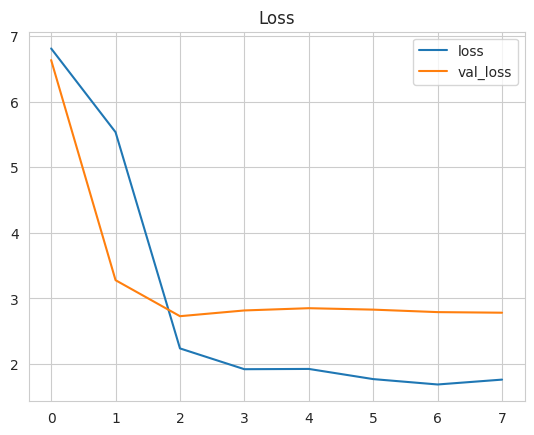

In [37]:
plt.plot(history_df["loss"])
plt.plot(history_df["val_loss"])
plt.title("Loss")
plt.legend(["loss", "val_loss"])
plt.show()


In [38]:
def translate(text):
    text = en_tokenizer.texts_to_sequences([text])
    text = pad_sequences(text, maxlen=en_maxlen, padding='post')
    prediction = model.predict(text, verbose=0)[0]
    integers = [np.argmax(preds) for preds in prediction]
    target = [fr_tokenizer.index_word.get(integer, None) for integer in integers]
    translated = ' '.join([t for t in target if t != None])
    return translated

translate("أوناك")

''

In [39]:
raw, actual_results, predicted_results = [], [], []
bleu_scores = []
for i, text in enumerate(X_test):
    text = text.reshape((1, text.shape[0]))
    prediction = model.predict(text, verbose=0)[0]
    integers = [np.argmax(preds) for preds in prediction]
    target = [fr_tokenizer.index_word.get(integer, None) for integer in integers]
    translated = ' '.join([t for t in target if t != None])
    predicted_results.append(translated)
    actual_results.append(test_data[i, idx_fr])
    raw.append(test_data[i, idx_en])
    bleu_scores.append(corpus_bleu([test_data[i, idx_fr].split()], [translated.split()],  weights=(1.0, 0, 0, 0)))

result_df = pd.DataFrame({
    "arabic": raw,
    "ar-sana`a (Actual)": actual_results,
    "ar-sana`a (Predicted)": predicted_results,
    "BLEU": bleu_scores,
})

result_df.sample(5)

,arabic,ar-sana`a (Actual),ar-sana`a (Predicted),BLEU
8,سُعيدك,هنيت لك مثال سعيدك معاك فلوس اغبطك لئنك لديك مال,,0
31,أوناك,هنالك,,0
10,الجونية,الشوالة,,0
5,ايش بُك,ماذا دهاك او ماذا بك,,0
35,حالي,جميل,,0
